In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

2024-09-26 17:32:58.771690: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 17:32:58.780871: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 17:32:59.005252: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 17:32:59.291386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 17:32:59.544004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
def preprocess_image(lr_img, hr_img):
    hr_img = tf.image.central_crop(hr_img, central_fraction=0.5)
    hr_img = tf.image.resize(hr_img, (224, 224))
    lr_img = tf.image.resize(hr_img, (112, 112))
    lr_img = tf.image.resize(lr_img, (224, 224))
    return lr_img, hr_img

def load_div2k_dataset(num_samples=100):
    dataset = tfds.load('div2k', split='train', as_supervised=True)
    dataset = dataset.take(num_samples)
    lr_images = []
    hr_images = []
    for lr_img, hr_img in tfds.as_numpy(dataset):
        lr_img, hr_img = preprocess_image(lr_img, hr_img)
        lr_images.append(lr_img)
        hr_images.append(hr_img)
    return np.array(lr_images), np.array(hr_images)

lr_images, hr_images = load_div2k_dataset()

2024-09-26 17:33:22.694690: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
def split_data(lr_images, hr_images, train_ratio=0.6, val_ratio=0.2):
    lr_train, lr_temp, hr_train, hr_temp = train_test_split(lr_images, hr_images, train_size=train_ratio)
    val_size = val_ratio / (1 - train_ratio)
    lr_val, lr_test, hr_val, hr_test = train_test_split(lr_temp, hr_temp, train_size=val_size)
    return lr_train, lr_val, lr_test, hr_train, hr_val, hr_test

lr_train, lr_val, lr_test, hr_train, hr_val, hr_test = split_data(lr_images, hr_images)

In [4]:
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=255.0)

In [5]:
def build_srcnn_model():
    input_layer = layers.Input(shape=(224, 224, 3))
    x = layers.Conv2D(64, (9, 9), activation='relu', padding='same')(input_layer)
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = layers.Conv2D(3, (5, 5), activation='linear', padding='same')(x)
    output_layer = layers.Add()([input_layer, x])
    model = models.Model(inputs=input_layer, outputs=output_layer)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error', metrics=[psnr_metric])
    return model

srcnn_model = build_srcnn_model()

In [6]:
def build_srcnn_reg_model(reg_factor=1e-4):
    model = models.Sequential([
        layers.Conv2D(64, (9, 9), activation='relu', padding='same', kernel_regularizer=regularizers.l2(reg_factor), input_shape=(224, 224, 3)),
        layers.Conv2D(32, (5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(reg_factor)),
        layers.Conv2D(3, (5, 5), activation='linear', padding='same')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=[psnr_metric])
    return model

srcnn_reg_model = build_srcnn_reg_model()

/home/miljan/Image-Super-Resolution/my_env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
def build_srcnn_tanh_model():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        layers.Lambda(lambda x: (x / 127.5) - 1.0),  # Normalize to [-1, 1]
        layers.Conv2D(64, (9, 9), activation='tanh', padding='same'),
        layers.Conv2D(32, (5, 5), activation='tanh', padding='same'),
        layers.Conv2D(3, (5, 5), activation='tanh', padding='same'),
        layers.Lambda(lambda x: (x + 1.0) * 127.5)  # De-normalize to [0, 255]
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=[psnr_metric])
    return model

srcnn_tanh_model = build_srcnn_tanh_model()

In [8]:
def build_srcnn_batchnorm_model():
    model = models.Sequential([
        layers.Conv2D(64, (9, 9), padding='same', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, (5, 5), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(3, (5, 5), activation='linear', padding='same')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='mean_squared_error', metrics=[psnr_metric])
    return model

srcnn_batchnorm_model = build_srcnn_batchnorm_model()

In [9]:
def train_model(model, lr_train, hr_train, lr_val, hr_val, epochs=100, batch_size=2):
    history = model.fit(lr_train, hr_train, validation_data=(lr_val, hr_val), epochs=epochs, batch_size=batch_size)
    return history

In [10]:
history_srcnn = train_model(srcnn_model, lr_train, hr_train, lr_val, hr_val)
history_srcnn_reg = train_model(srcnn_reg_model, lr_train, hr_train, lr_val, hr_val)
history_srcnn_tanh = train_model(srcnn_tanh_model, lr_train, hr_train, lr_val, hr_val)
history_srcnn_batchnorm = train_model(srcnn_batchnorm_model, lr_train, hr_train, lr_val, hr_val)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - loss: 463.6730 - psnr_metric: 22.2770 - val_loss: 372.6492 - val_psnr_metric: 23.4306
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - loss: 332.0039 - psnr_metric: 23.6813 - val_loss: 360.1586 - val_psnr_metric: 23.6209
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - loss: 299.5912 - psnr_metric: 24.3762 - val_loss: 351.7209 - val_psnr_metric: 23.7440
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 289ms/step - loss: 392.3901 - psnr_metric: 23.3738 - val_loss: 344.5764 - val_psnr_metric: 23.8634
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step - loss: 323.8602 - psnr_metric: 23.8326 - val_loss: 339.3213 - val_psnr_metric: 23.9462
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - loss: 305.3308 - psnr_metric: 24.6970 - val_loss: 336.1248 - val_psnr_metric: 23.9948
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step - loss: 347.4459 - psnr_metric: 23.7674 - val_loss: 334.6699 - val_psnr_metric: 24.0072
Epoch 8/10

In [11]:
def evaluate_model(model, lr_test, hr_test):
    psnr_values = []
    for lr_img, hr_img in zip(lr_test, hr_test):
        sr_img = model.predict(np.expand_dims(lr_img, axis=0))
        psnr_value = tf.image.psnr(hr_img, sr_img[0], max_val=255.0).numpy()
        psnr_values.append(psnr_value)
    return np.mean(psnr_values)

psnr_srcnn = evaluate_model(srcnn_model, lr_test, hr_test)
psnr_srcnn_reg = evaluate_model(srcnn_reg_model, lr_test, hr_test)
psnr_srcnn_tanh = evaluate_model(srcnn_tanh_model, lr_test, hr_test)
psnr_srcnn_batchnorm = evaluate_model(srcnn_batchnorm_model, lr_test, hr_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [12]:
def simple_model_evaluation(lr_images, hr_images, method='bicubic'):
    sr_images = []
    for lr_img in lr_images:
        if method == 'bicubic':
            sr_img = tf.image.resize(lr_img, (224, 224), method=tf.image.ResizeMethod.BICUBIC)
        elif method == 'bilinear':
            sr_img = tf.image.resize(lr_img, (224, 224), method=tf.image.ResizeMethod.BILINEAR)
        elif method == 'nearest':
            sr_img = tf.image.resize(lr_img, (224, 224), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        sr_images.append(sr_img)
    psnr_values = [tf.image.psnr(hr, sr, max_val=255.0).numpy() for hr, sr in zip(hr_images, sr_images)]
    return np.mean(psnr_values)

psnr_bicubic = simple_model_evaluation(lr_test, hr_test, method='bicubic')
psnr_bilinear = simple_model_evaluation(lr_test, hr_test, method='bilinear')
psnr_nearest = simple_model_evaluation(lr_test, hr_test, method='nearest')

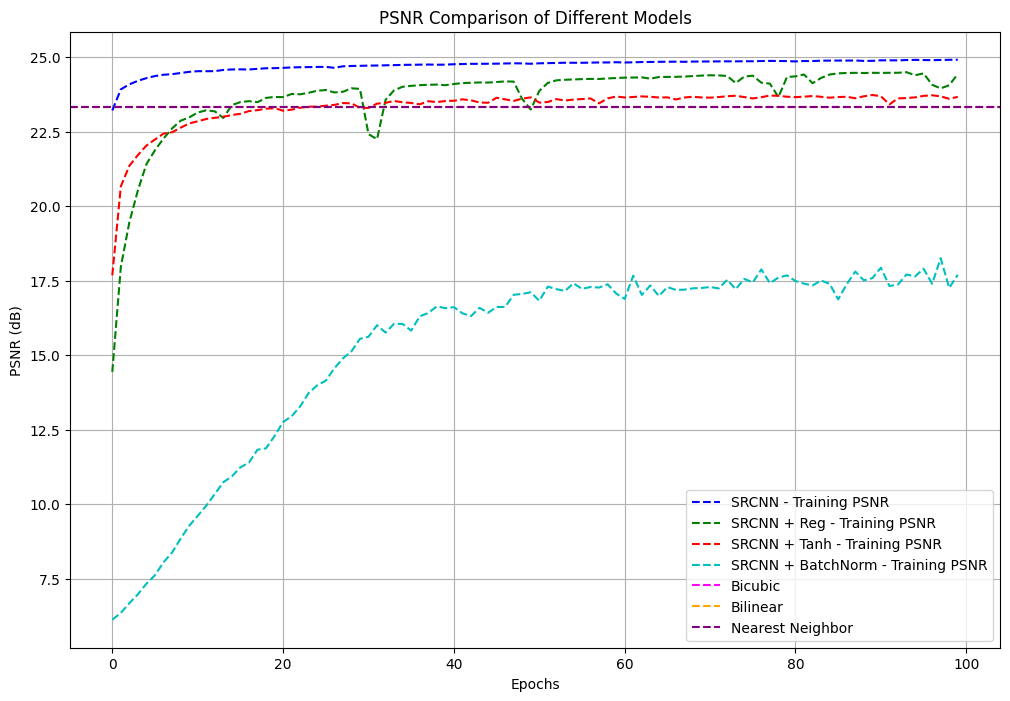

In [13]:
def plot_psnr_results(histories, simple_psnr, labels):
    plt.figure(figsize=(12, 8))
    colors = ['b', 'g', 'r', 'c']
    for history, label, color in zip(histories, labels, colors):
        if 'val_psnr' in history.history:
            plt.plot(history.history['val_psnr'], color=color, label=f'{label} - Validation PSNR')
        if 'psnr_metric' in history.history:
            plt.plot(history.history['psnr_metric'], '--', color=color, label=f'{label} - Training PSNR')
    plt.axhline(y=simple_psnr[0], color='magenta', linestyle='--', label='Bicubic')
    plt.axhline(y=simple_psnr[1], color='orange', linestyle='--', label='Bilinear')
    plt.axhline(y=simple_psnr[2], color='purple', linestyle='--', label='Nearest Neighbor')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR Comparison of Different Models')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_psnr_results(
    [history_srcnn, history_srcnn_reg, history_srcnn_tanh, history_srcnn_batchnorm], 
    [psnr_bicubic, psnr_bilinear, psnr_nearest], 
    ['SRCNN', 'SRCNN + Reg', 'SRCNN + Tanh', 'SRCNN + BatchNorm']
)

In [14]:
def report_results(history_srcnn, history_srcnn_reg, history_srcnn_tanh, history_srcnn_batchnorm, psnr_bicubic, psnr_bilinear, psnr_nearest, psnr_srcnn, psnr_srcnn_reg, psnr_srcnn_tanh, psnr_srcnn_batchnorm):
    results = {
        'Model': ['SRCNN', 'SRCNN + Regularization', 'SRCNN + Tanh', 'SRCNN + Batch Norm', 'Bicubic', 'Bilinear', 'Nearest Neighbor'],
        'Validation PSNR (dB)': [
            max(history_srcnn.history['psnr_metric']),
            max(history_srcnn_reg.history['psnr_metric']),
            max(history_srcnn_tanh.history['psnr_metric']),
            max(history_srcnn_batchnorm.history['psnr_metric']),
            psnr_bicubic,
            psnr_bilinear,
            psnr_nearest
        ],
        'Test PSNR (dB)': [
            psnr_srcnn,
            psnr_srcnn_reg,
            psnr_srcnn_tanh,
            psnr_srcnn_batchnorm,
            psnr_bicubic,
            psnr_bilinear,
            psnr_nearest
        ]
    }
    
    print("{:<30} {:<20} {:<20}".format('Model', 'Validation PSNR (dB)', 'Test PSNR (dB)'))
    print("=" * 70)
    for model, val_psnr, test_psnr in zip(results['Model'], results['Validation PSNR (dB)'], results['Test PSNR (dB)']):
        print("{:<30} {:<20.4f} {:<20.4f}".format(model, val_psnr, test_psnr))

report_results(
    history_srcnn, 
    history_srcnn_reg, 
    history_srcnn_tanh, 
    history_srcnn_batchnorm, 
    psnr_bicubic, 
    psnr_bilinear, 
    psnr_nearest, 
    psnr_srcnn, 
    psnr_srcnn_reg, 
    psnr_srcnn_tanh, 
    psnr_srcnn_batchnorm
)

Model                          Validation PSNR (dB) Test PSNR (dB)      
SRCNN                          24.9086              24.3184             
SRCNN + Regularization         24.4907              23.6835             
SRCNN + Tanh                   23.7259              23.2115             
SRCNN + Batch Norm             18.2518              19.0217             
Bicubic                        23.3254              23.3254             
Bilinear                       23.3254              23.3254             
Nearest Neighbor               23.3254              23.3254             


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


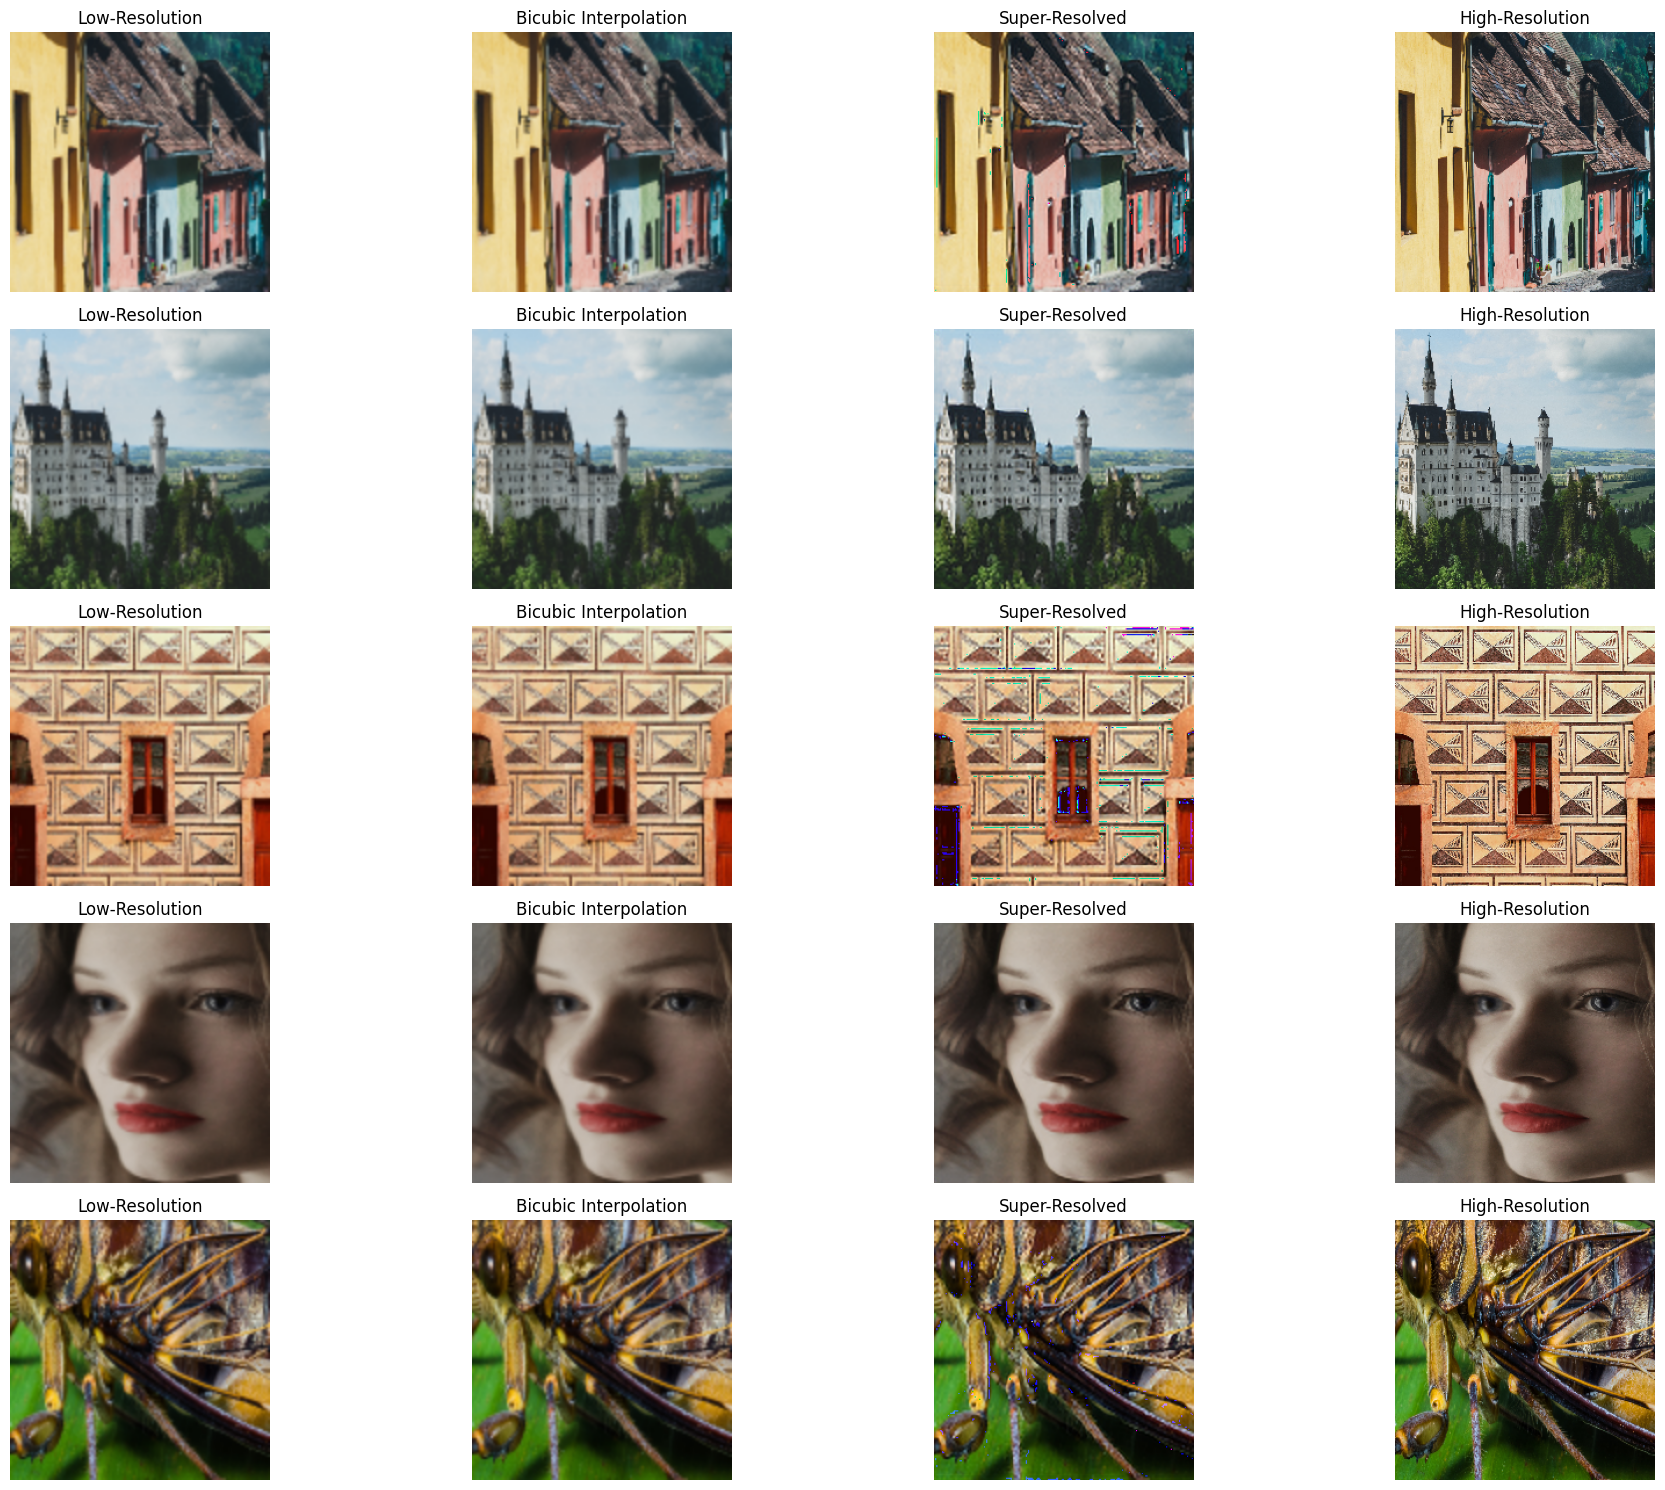

In [16]:
def display_images(model, lr_test, hr_test, num_images=5):
    plt.figure(figsize=(20, 15))  

    for i in range(num_images):
        lr_img = lr_test[i]
        hr_img = hr_test[i]

        sr_img = model.predict(np.expand_dims(lr_img, axis=0))[0]

        bicubic_img = tf.image.resize(lr_img, (224, 224), method=tf.image.ResizeMethod.BICUBIC).numpy()

        plt.subplot(num_images, 4, 4*i + 1)
        plt.imshow(lr_img.astype(np.uint8))
        plt.title('Low-Resolution')
        plt.axis('off')

        plt.subplot(num_images, 4, 4*i + 2)
        plt.imshow(bicubic_img.astype(np.uint8))
        plt.title('Bicubic Interpolation')
        plt.axis('off')

        plt.subplot(num_images, 4, 4*i + 3)
        plt.imshow(sr_img.astype(np.uint8))
        plt.title('Super-Resolved')
        plt.axis('off')

        plt.subplot(num_images, 4, 4*i + 4)
        plt.imshow(hr_img.astype(np.uint8))
        plt.title('High-Resolution')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_images(srcnn_model, lr_test, hr_test)